In [1]:
!git clone https://github.com/IanChen5273/Music-emotion.git

Cloning into 'Music-emotion'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 490 (delta 0), reused 3 (delta 0), pack-reused 487
Receiving objects: 100% (490/490), 520.56 MiB | 14.24 MiB/s, done.
Updating files: 100% (457/457), done.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
      #tf.config.experimental.set_virtual_devices('GPU')
      for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        

2021-11-25 16:04:59.917129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-11-25 16:05:00.790871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-25 16:05:01.410393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:01:00.0
2021-11-25 16:05:01.410425: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-25 16:05:01.414294: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-25 16:05:01.416016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2021-11-25 16:05:01.416220: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2021-11-25 16:05:01.416644: I tensorflow/stream_executor/platform/default/dso_loa

In [3]:
import joblib
import librosa
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, add, Flatten, Dropout, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import xlrd

In [4]:
DataPath = '/workspace/Project1/Music-emotion/music-emotion/song/'
os.chdir(DataPath)
xlsx_module = xlrd.open_workbook('MusicData.xlsx')
xlsx_sheet = xlsx_module.sheets()[0]
data_info = []
for i in range(1, xlsx_sheet.nrows):
    data_info.append(xlsx_sheet.row_values(i))

In [5]:
class SVM:
    def __init__(self):
        pass

    def Train(self, DataPath):
        """Train data with SVM model

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        Features, Labels = self.LoadFeature(DataPath)

        #MeanValue = np.array(np.mean(Features, axis=0))
        #DiffValue = np.array(np.max(Features, axis=0) - np.min(Features, axis=0))
        #Features = (Features - MeanValue) / DiffValue

        X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.1, random_state=42)

        svm_model = svm.SVC(kernel='rbf', C=1, gamma='scale')
        svm_model.fit(X_train, y_train.ravel())
        joblib.dump(svm_model, 'music00')

        print('train = ', svm_model.score(X_train, y_train))
        print('val = ', svm_model.score(X_test, y_test))

    def Predict(self, ModelPath, InputData):
        """Predict the input with the given model

        Parameters
        ----------
        ModelPath : string
            The path where you store the model.
        InputData : string
            The path of input data, predict one data at one time.
        """
        X_test = self.FeatureExtraction(InputData)
        loaded_model = joblib.load(ModelPath)
        result = loaded_model.predict(X_test)

        return result

    def FeatureExtraction(self, DataPath):
        """Extract the feature for the given file

        Parameters
        ----------
        DataPath : string
            The path where your data is, only allows the file of wav and wma format.
        """
        y, sr = librosa.load(DataPath, sr=22050, mono=True, duration=4)
        time = librosa.get_duration(y=y, sr=sr)
        if int(time) < 4:
            return None

        feature_mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=sr, n_mfcc=1)
        feature_mfcc = feature_mfcc.reshape((1, feature_mfcc.shape[1] * feature_mfcc.shape[0]))
        feature_rolloff = librosa.feature.spectral_rolloff(y=y, sr=22050, hop_length=sr, roll_percent=0.85)
        feature_spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=22050, hop_length=sr, n_bands=1)
        feature_spectral_contrast = feature_spectral_contrast.reshape(
            (1, feature_spectral_contrast.shape[1] * feature_spectral_contrast.shape[0]))
        feature_rms = librosa.feature.rms(y=y, hop_length=sr)
        feature_combine = np.hstack((feature_rms, feature_mfcc))
        feature_combine = np.hstack((feature_combine, feature_rolloff))
        feature_combine = np.hstack((feature_combine, feature_spectral_contrast))

        return feature_combine

    def LoadFeature(self, DataPath):
        """Load features and labels from the directory.

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        os.chdir(DataPath)
        xlsx_module = xlrd.open_workbook('MusicData.xlsx')
        xlsx_sheet = xlsx_module.sheets()[0]
        data_info = []
        for i in range(1, xlsx_sheet.nrows):
            data_info.append(xlsx_sheet.row_values(i))

        features = np.array([])
        music_label = []
        for i in range(len(data_info)):
            print("\rExtracting feature ({}/{})".format(i, len(data_info)), flush=True, end='')
            print(" : {}/{}".format(data_info[i][1], data_info[i][2] + data_info[i][5]), flush=True, end='')

            os.chdir(data_info[i][1])

            feature = self.FeatureExtraction(data_info[i][2] + data_info[i][5])
            os.chdir('..')

            if feature is None:
                continue

            if features.shape[0] == 0:
                features = feature
            else:
                features = np.vstack((features, feature))

            arousal_s = data_info[i][3] - 50
            valence_s = data_info[i][4] - 50
            if arousal_s >= 0 and valence_s >= 0:  # Joy
                music_label.append(0)
            elif arousal_s >= 0 and valence_s < 0:  # Tension
                music_label.append(1)
            elif arousal_s < 0 and valence_s >= 0:  # Peacefulness
                music_label.append(2)
            elif arousal_s < 0 and valence_s < 0:  # Sadness
                music_label.append(3)

        os.chdir('..')
        print('\rExtract complete', flush=True)

        return features, np.array(music_label)

In [6]:
model = SVM()
model.Train('/workspace/Project1/Music-emotion/music-emotion/song')
result = model.Predict('/workspace/Project1/Music-emotion/music-emotion/music00',DataPath+"/Four Seasons_Summer 3rd movment/split_002.wav")
print(result)

Extracting feature (67/450): Grand_Polonaise_op_16/split_001.wav : Grand_Polonaise_op_16/split_002.wav : Grand_Polonaise_op_16/split_003.wav : Grand_Polonaise_op_16/split_004.wav : Grand_Polonaise_op_16/split_005.wav : Grand_Polonaise_op_16/split_006.wav : Grand_Polonaise_op_16/split_007.wav : Grand_Polonaise_op_16/split_008.wav : Grand_Polonaise_op_16/split_009.wav : Four Seasons_Summer 3rd movment/split_001.wav : Four Seasons_Summer 3rd movment/split_002.wav : Four Seasons_Summer 3rd movment/split_003.wav : Four Seasons_Summer 3rd movment/split_004.wav : Four Seasons_Summer 3rd movment/split_005.wav : Four Seasons_Summer 3rd movment/split_006.wav : Four Seasons_Summer 3rd movment/split_007.wav : Four Seasons_Summer 3rd movment/split_008.wav : Four Seasons_Summer 3rd movment/split_009.wav : Four Seasons_Summer 3rd movment/split_010.wav : Four Seasons_Summer 3rd movment/split_011.wav : Four Seasons_Summer 3rd movment/split_012.wav : Four Seasons_Summer 3rd movment/split_013.wav : Four 

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (68/450) : L_ Horloge de Flore mv_II/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (69/450) : L_ Horloge de Flore mv_II/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (70/450) : L_ Horloge de Flore mv_II/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (71/450) : L_ Horloge de Flore mv_II/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (72/450) : L_ Horloge de Flore mv_II/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (73/450) : L_ Horloge de Flore mv_II/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (74/450) : L_ Horloge de Flore mv_II/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (75/450) : L_ Horloge de Flore mv_II/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (76/450) : L_ Horloge de Flore mv_II/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (77/450) : L_ Horloge de Flore mv_II/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (78/450) : L_ Horloge de Flore mv_II/split_012.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (79/450) : L_ Horloge de Flore mv_II/split_013.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (80/450) : L_ Horloge de Flore mv_II/split_014.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (81/450) : L_ Horloge de Flore mv_II/split_015.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (82/450) : L_ Horloge de Flore mv_II/split_016.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (83/450) : L_ Horloge de Flore mv_II/split_017.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (84/450) : L_ Horloge de Flore mv_II/split_018.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (85/450) : L_ Horloge de Flore mv_II/split_019.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (86/450) : L_ Horloge de Flore mv_II/split_020.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (87/450) : L_ Horloge de Flore mv_II/split_021.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (88/450) : L_ Horloge de Flore mv_II/split_022.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (89/450) : L_ Horloge de Flore mv_II/split_023.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (173/450): Etude Op_72 No_2/split_001.wav : Etude Op_72 No_2/split_002.wav : Etude Op_72 No_2/split_003.wav : Etude Op_72 No_2/split_004.wav : Etude Op_72 No_2/split_005.wav : Etude Op_72 No_2/split_006.wav : Etude Op_72 No_2/split_007.wav : Etude Op_72 No_2/split_008.wav : Etude Op_72 No_2/split_009.wav : Etude Op_72 No_2/split_010.wav : Etude Op_72 No_2/split_011.wav : Etude Op_72 No_2/split_012.wav : Etude Op_72 No_2/split_013.wav : Etude Op_72 No_2/split_014.wav : Etude Op_72 No_2/split_015.wav : Elegy/split_001.wav : Elegy/split_002.wav : Elegy/split_003.wav : Elegy/split_004.wav : Elegy/split_005.wav : Elegy/split_006.wav : Elegy/split_007.wav : Elegy/split_008.wav : Elegy/split_009.wav : Elegy/split_010.wav : Elegy/split_011.wav : Elegy/split_012.wav : Elegy/split_013.wav : Elegy/split_014.wav : Elegy/split_015.wav : Elegy/split_016.wav : Elegy/split_017.wav : Elegy/split_018.wav : Elegy/split_019.wav : Elegy/split_020.wav : Elegy/split_021.wav : Horn concerto

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (174/450) : Gabriel_s Oboe from The mission/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (175/450) : Gabriel_s Oboe from The mission/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (176/450) : Gabriel_s Oboe from The mission/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (177/450) : Gabriel_s Oboe from The mission/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (178/450) : Gabriel_s Oboe from The mission/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (179/450) : Gabriel_s Oboe from The mission/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (180/450) : Gabriel_s Oboe from The mission/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (181/450) : Gabriel_s Oboe from The mission/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (182/450) : Gabriel_s Oboe from The mission/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (183/450) : Gabriel_s Oboe from The mission/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (353/450) : Op_28 Preludes No_8/split_001.wav : Op_28 Preludes No_8/split_002.wav : Op_28 Preludes No_8/split_003.wav : Op_28 Preludes No_8/split_004.wav : Op_28 Preludes No_8/split_005.wav : Op_28 Preludes No_8/split_006.wav : Op_28 Preludes No_8/split_007.wav : Op_28 Preludes No_8/split_008.wav : Op_28 Preludes No_8/split_009.wav : Op_28 Preludes No_8/split_010.wav : Op_28 Preludes No_8/split_011.wav : Op_28 Preludes No_8/split_012.wav : Op_28 Preludes No_8/split_013.wav : Nocturne/split_001.wav : Nocturne/split_002.wav : Nocturne/split_003.wav : Nocturne/split_004.wav : Nocturne/split_005.wav : Nocturne/split_006.wav : Nocturne/split_007.wav : Nocturne/split_008.wav : Nocturne/split_009.wav : Nocturne/split_010.wav : Nocturne/split_011.wav : Nocturne/split_012.wav : Nocturne/split_013.wav : Nocturne/split_014.wav : Nocturne/split_015.wav : Nocturne/split_016.wav : Nocturne/split_017.wav : Nocturne/split_018.wav : Nocturne/split_019.wav : Nocturne/split_020.wav : N

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (354/450) : Adagio from the Easter Oratorio/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (355/450) : Adagio from the Easter Oratorio/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (356/450) : Adagio from the Easter Oratorio/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (357/450) : Adagio from the Easter Oratorio/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (358/450) : Adagio from the Easter Oratorio/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (359/450) : Adagio from the Easter Oratorio/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (360/450) : Adagio from the Easter Oratorio/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (361/450) : Adagio from the Easter Oratorio/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (362/450) : Adagio from the Easter Oratorio/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (363/450) : Adagio from the Easter Oratorio/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (364/450) : Adagio from the Easter Oratorio/split_012.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (365/450) : Adagio from the Easter Oratorio/split_013.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (366/450) : Adagio from the Easter Oratorio/split_014.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (367/450) : Adagio from the Easter Oratorio/split_015.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (368/450) : Adagio from the Easter Oratorio/split_016.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (369/450) : Adagio from the Easter Oratorio/split_017.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (386/450) : Rebonds B/split_001.wav : Rebonds B/split_002.wav : Rebonds B/split_003.wav : Rebonds B/split_004.wav : Rebonds B/split_005.wav : Rebonds B/split_006.wav : Rebonds B/split_007.wav : Rebonds B/split_008.wav : Symphony no_5 Mvt_II/split_001.wav : Symphony no_5 Mvt_II/split_002.wav : Symphony no_5 Mvt_II/split_003.wav : Symphony no_5 Mvt_II/split_004.wav : Symphony no_5 Mvt_II/split_005.wav : Symphony no_5 Mvt_II/split_006.wav : Symphony no_5 Mvt_II/split_007.wav : Symphony no_5 Mvt_II/split_008.wav : Concerto for oboe and small orchestra mv_I/split_001.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (387/450) : Concerto for oboe and small orchestra mv_I/split_002.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (388/450) : Concerto for oboe and small orchestra mv_I/split_003.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (389/450) : Concerto for oboe and small orchestra mv_I/split_004.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (390/450) : Concerto for oboe and small orchestra mv_I/split_005.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (391/450) : Concerto for oboe and small orchestra mv_I/split_006.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (392/450) : Concerto for oboe and small orchestra mv_I/split_007.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (393/450) : Concerto for oboe and small orchestra mv_I/split_008.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (394/450) : Concerto for oboe and small orchestra mv_I/split_009.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (395/450) : Concerto for oboe and small orchestra mv_I/split_010.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (396/450) : Concerto for oboe and small orchestra mv_I/split_011.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (397/450) : Concerto for oboe and small orchestra mv_I/split_012.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (398/450) : Concerto for oboe and small orchestra mv_I/split_013.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (399/450) : Concerto for oboe and small orchestra mv_I/split_014.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (400/450) : Concerto for oboe and small orchestra mv_I/split_015.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (401/450) : Concerto for oboe and small orchestra mv_I/split_016.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (402/450) : Concerto for oboe and small orchestra mv_I/split_017.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (403/450) : Concerto for oboe and small orchestra mv_I/split_018.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (404/450) : Concerto for oboe and small orchestra mv_I/split_019.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (405/450) : Concerto for oboe and small orchestra mv_I/split_020.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (406/450) : Concerto for oboe and small orchestra mv_I/split_021.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (407/450) : Concerto for oboe and small orchestra mv_I/split_022.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (408/450) : Concerto for oboe and small orchestra mv_I/split_023.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extracting feature (409/450) : Concerto for oboe and small orchestra mv_I/split_024.wma

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Extract completere (449/450) : Siciliana/split_001.wav : Siciliana/split_002.wav : Siciliana/split_003.wav : Siciliana/split_004.wav : Siciliana/split_005.wav : Siciliana/split_006.wav : Siciliana/split_007.wav : Siciliana/split_008.wav : Siciliana/split_009.wav : Siciliana/split_010.wav : Siciliana/split_011.wav : Siciliana/split_012.wav : Siciliana/split_013.wav : Adagio Religioso/split_001.wav : Adagio Religioso/split_002.wav : Adagio Religioso/split_003.wav : Adagio Religioso/split_004.wav : Adagio Religioso/split_005.wav : Adagio Religioso/split_006.wav : Adagio Religioso/split_007.wav : Adagio Religioso/split_008.wav : Adagio Religioso/split_009.wav : Adagio Religioso/split_010.wav : Adagio Religioso/split_011.wav : Adagio Religioso/split_012.wav : Adagio Religioso/split_013.wav : Adagio Religioso/split_014.wav : Adagio Religioso/split_015.wav : Adagio Religioso/split_016.wav : Adagio Religioso/split_017.wav : Adagio Religioso/split_018.wav : Adagio Religioso/split_020.wav : Adag

In [7]:
import warnings
warnings.filterwarnings("ignore")
class CNN:
    def __init__(self, epoch=10, batch_size=8, verbose=1, sr=22050):
        self.org_path = os.getcwd()
        self.set_epoch = epoch
        self.set_batch_size = batch_size
        self.set_verbose = verbose
        self.sr = sr

    def LoadData(self, DataPath):
        """Load data from the directory.

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        os.chdir(DataPath)
        xlsx_module = xlrd.open_workbook('MusicData.xlsx')
        xlsx_sheet = xlsx_module.sheets()[0]
        data_info = []
        for i in range(1, xlsx_sheet.nrows):
            data_info.append(xlsx_sheet.row_values(i))
        music_data = []
        music_label = []
        data_len = []
        for i in range(len(data_info)):
            # print("\rLoading data ({}/{})".format(i, len(data_info)), flush=True, end='')
            # print(" : {}/{}".format(data_info[i][1], data_info[i][2] + data_info[i][5]), flush=True, end='')

            os.chdir(data_info[i][1])
            # raw_data, sr = librosa.load(data_info[i][2] + data_info[i][5], sr=22050, mono=True, offset=0.0, duration=4)
            raw_data, sr = librosa.load(data_info[i][2] + data_info[i][5], sr=self.sr, mono=True, offset=0.0, duration=4)
            music_data.append(raw_data)
            data_len.append(raw_data.size)
            arousal_s = data_info[i][3] - 50
            valence_s = data_info[i][4] - 50
            if arousal_s >= 0 and valence_s >= 0:  # Joy
                music_label.append(0)
            elif arousal_s >= 0 and valence_s < 0:  # Tension
                music_label.append(1)
            elif arousal_s < 0 and valence_s >= 0:  # Peacefulness
                music_label.append(2)
            elif arousal_s < 0 and valence_s < 0:  # Sadness
                music_label.append(3)
            os.chdir('..')
        music_label = np.array(music_label)
        data_len = np.array(data_len)

        last_index = np.where(data_len == sr * 4)[0]
        new_music_data = []
        new_music_label = []
        for i in range(last_index.size):
            new_music_data.append(music_data[last_index[i]])
            new_music_label.append(music_label[i])
        new_music_data = np.array(new_music_data)
        new_music_label = np.array(new_music_label)

        new_music_data = np.reshape(new_music_data, [new_music_label.size, 1, self.sr*4, 1])
        train_index, test_index = self.split_data(new_music_label, train_size=0.7)
        train_data = new_music_data[train_index, :, :, :]
        train_label = to_categorical(new_music_label[train_index])
        test_data = new_music_data[test_index, :, :, :]
        test_label = to_categorical(new_music_label[test_index])

        return train_data, train_label, test_data, test_label

    def split_data(self, label, train_size=0.7):
        import random
        uni_label = np.unique(label)
        uni_label_num = [[] for i in range(uni_label.size)]
        train_index = np.array([], dtype='uint32')
        for i in range(uni_label.size):
            uni_label_num = list(np.where(label == uni_label[i])[0])
            train_index = np.hstack(
                [train_index, np.array(random.sample(uni_label_num, k=int(len(uni_label_num) * train_size)))])
        train_index = np.sort(train_index)
        test_index = np.setdiff1d(np.arange(label.size), train_index)

        return train_index, test_index

    def CreateModel(self, InputShape):
        """Create CNN model

        Parameters
        ----------
        InputShape :
            The shape of training data
        """
        sig_input = Input(shape=InputShape)
        x1_1=Conv2D(128,(1,256),kernel_initializer='random_uniform',padding='same',data_format='channels_last')(sig_input)
        x1_1=(Activation('relu'))(x1_1)
        x1_1=(BatchNormalization())(x1_1)
        x1_1=MaxPooling2D((1,80),strides=(1,40),data_format='channels_last')(x1_1)
        x1_2=Conv2D(128,(1,512),kernel_initializer='random_uniform',padding='same',data_format='channels_last')(x1_1)
        x1_2=(Activation('relu'))(x1_2)
        x1_2=(BatchNormalization())(x1_2)
        x1_o=add([x1_1,x1_2])
        x2=Conv2D(32,(1,1024),kernel_initializer='random_uniform',padding='same',data_format='channels_last')(x1_o)
        x2=(Activation('relu'))(x2)
        x2=(BatchNormalization())(x2)
        x2=MaxPooling2D((1,80),strides=(1,40),data_format='channels_last')(x2)
        y=(Flatten())(x2)
        y=(Dropout(0.4))(y)
        y=(Dense(units=64,activation='relu'))(y)
        y=(Dropout(0.4))(y)
        output=(Dense(units=4,activation='softmax'))(y)
        model = Model(sig_input, output)

        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

    def Train(self, DataPath):
        """Train data with CNN model

        Parameters
        ----------
        DataPath : string
            The path where you store the data. Note that the path must contain every split music data and
            MusicData.xlsx
        """
        train_data, train_label, test_data, test_label = self.LoadData(DataPath)
        model = self.CreateModel(train_data.shape[1:])

        train_history = model.fit(x=train_data,
                                  y=train_label,
                                  validation_data=(test_data, test_label),
                                  epochs=self.set_epoch,
                                  batch_size=self.set_batch_size,
                                  verbose=self.set_verbose)
        os.chdir(self.org_path)
        model.save('music_cnn.model')

        # %% Model accuracy
        y1 = train_history.history['acc']
        y2 = train_history.history['val_acc']
        x = np.arange(len(y1)) + 1
        plt.plot(x, y1, color='blue', label='Train')
        plt.plot(x, y2, color='red', label='Validation')
        plt.title("accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend(loc='upper left', shadow=True)
        plt.savefig('accuracy', dpi=1500)
        plt.show()

        # %% Model loss value
        y1 = train_history.history['loss']


        y2 = train_history.history['val_loss']
        x = np.arange(len(y1)) + 1
        plt.plot(x, y1, color='blue', label='Train')
        plt.plot(x, y2, color='red', label='Validation')
        plt.title("loss")
        plt.xlabel("Epoch")
        plt.ylabel("loss")
        plt.legend(loc='upper right', shadow=True)
        plt.savefig('loss', dpi=1500)
        plt.show()

    def Predict(self, ModelPath, InputData):
        """Predict the input with the given model

        Parameters
        ----------
        ModelPath : string
            The path where you store the model.
        InputData : string
            The path of input data, predict one data at one time.
        """
        raw_data, sr = librosa.load(InputData, sr=self.sr, mono=True, offset=0.0, duration=4)
        model = load_model(ModelPath)
        music_data = np.reshape(raw_data, [1, 1, self.sr*4, 1])
        score = model.predict(music_data)
        pre_label = np.argmax(score)

        return pre_label

Train on 296 samples, validate on 129 samples
Epoch 1/10
296/296 [==============================] - 6s 21ms/sample - loss: 3.0209 - acc: 0.2770 - val_loss: 2.4718 - val_acc: 0.3721
Epoch 2/10
296/296 [==============================] - 6s 19ms/sample - loss: 2.1528 - acc: 0.2872 - val_loss: 1.8150 - val_acc: 0.3566
Epoch 3/10
296/296 [==============================] - 5s 18ms/sample - loss: 2.0329 - acc: 0.3514 - val_loss: 2.3275 - val_acc: 0.1318
Epoch 4/10
296/296 [==============================] - 6s 19ms/sample - loss: 1.9281 - acc: 0.3750 - val_loss: 2.3896 - val_acc: 0.2946
Epoch 5/10
296/296 [==============================] - 5s 18ms/sample - loss: 1.6080 - acc: 0.4122 - val_loss: 2.6629 - val_acc: 0.3566
Epoch 6/10
296/296 [==============================] - 5s 17ms/sample - loss: 1.6158 - acc: 0.3885 - val_loss: 2.3225 - val_acc: 0.3798
Epoch 7/10
296/296 [==============================] - 5s 17ms/sample - loss: 1.4968 - acc: 0.3750 - val_loss: 1.3827 - val_acc: 0.3101
Epoch 8/1

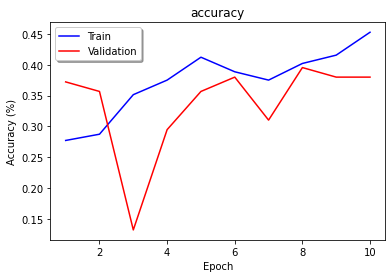

In [ ]:
model = CNN()
model.Train(DataPath)
result = model.Predict('/workspace/Project1/Music-emotion/music-emotion/music_cnn.model', DataPath+"Four Seasons_Summer 3rd movment/split_002.wav")
print(result)